In [417]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import h5py
import os
import seaborn as sns
from pyscf.scf.uhf import det_ovlp

In [181]:
# Wavefunction generation
from pyscf import lib, gto, scf
from pyscf import gto, mp, mcscf
def He_casci(scf_checkfile, ci_checkfile):
    mol = gto.M(
        atom="He 0. 0. 0.0;",
        basis=f"ccecpccpvqz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.UHF(mol).run()
    mf.chkfile = scf_checkfile
    mf.kernel()
    mc = mcscf.CASCI(mf, 2,2)
    # mc.fcisolver.nroots = 2
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff    
    return mol, mf, mc

In [182]:
scf_checkfile = 'rohf.chk'
ci_checkfile = 'casci.chk'
for fname in [scf_checkfile, ci_checkfile]:
    if os.path.isfile(fname):
        os.remove(fname)
mol, mf, mcc = He_casci(scf_checkfile, ci_checkfile)


dict_keys(['mol', '_scf', 'verbose', 'stdout', 'max_memory', 'ncas', 'nelecas', '_ncore', 'fcisolver', 'frozen', 'extrasym', 'e_tot', 'e_cas', 'ci', 'mo_coeff', 'mo_energy', 'mo_occ', 'converged'])


In [183]:
# Orthogonality test

(30, 30)


<Axes: >

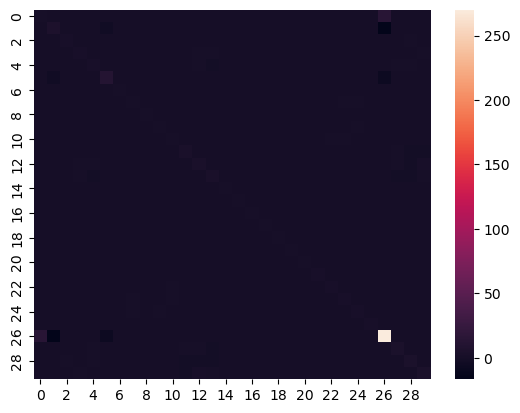

In [184]:
# FC = SCE Roothaan equation
C = mf.mo_coeff
Ca = C[0]
print(Ca.shape)
# C.T @ C
s0 = np.einsum('ij, jk->ik', Ca.T, Ca)
sns.heatmap(s0)

<Axes: >

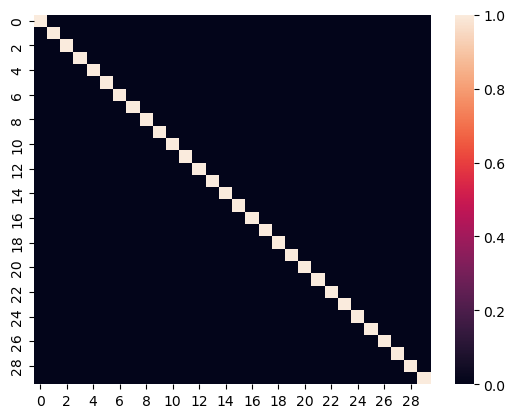

In [185]:
# C.T @ S @ C
s1 = np.einsum('ij, jk, kl->il', Ca.T, mf.get_ovlp(), Ca)
sns.heatmap(s1)
# Orthogonal in the overlap metric (get_ovlp)

# Using PYSCF method using output from PYQMC_1

In [186]:
import bosonslater 
import pyscftools, mc
wf1 = bosonslater.BosonWF(mol, mf, mc=mcc)

nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
# wf.parameters['det_coeff'] = np.ones(len(wf.parameters['det_coeff']))
signb, phib = wf1.recompute(configs)
num_ao = wf1._aovals.shape[-1]
print(num_ao)

30


In [187]:
det_dim_up = wf1._dets[0][1].shape[-1]
det_dim = det_dim_up
print(det_dim_up, ' up determinants')

2  up determinants


In [188]:
det_dim_dn = wf1._dets[1][1].shape[-1]
print(det_dim_dn, ' down determinants')
print(det_dim_up * det_dim_dn, ' total number of determinants')


2  down determinants
4  total number of determinants


In [189]:
mcc_mo_coeff=copy.deepcopy(mf.mo_coeff)

In [190]:
n = np.array(wf1._det_occup)
print(n.shape)
occ_arr_shape = (n.shape[0], n.shape[1], num_ao)
occ_arr = np.zeros(occ_arr_shape)
for i in range(n.shape[0]):
    for j in range(n.shape[1]):
        occ_arr[i,j][n[i,j]]=1

(2, 2, 1)


In [191]:
occ_arr.shape

(2, 2, 30)

In [192]:
ovlp_mat = np.zeros((det_dim, det_dim))
for i1 in range(det_dim):
    for i2 in range(det_dim):
        det1_occ = np.array([occ_arr[0, i1], occ_arr[1, i1]])
        det2_occ = np.array([occ_arr[0, i2], occ_arr[1, i2]])
        # print(det1_occ, '\n\n', det2_occ, '\n===\n')
        ovlp, _ = det_ovlp(mcc_mo_coeff, mcc_mo_coeff, det1_occ, det2_occ, mf.get_ovlp())
        ovlp_mat[i1, i2] = ovlp

<Axes: >

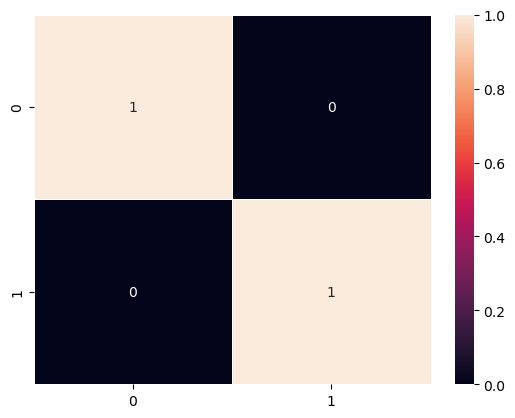

In [193]:
sns.heatmap(np.round(ovlp_mat,5), annot=True, linewidths=.5)

# PYSCF method 2

In [194]:
import bosonslater 
import pyscftools, mc
wf1 = bosonslater.BosonWF(mol, mf, mc=mcc)

nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
# wf.parameters['det_coeff'] = np.ones(len(wf.parameters['det_coeff']))
signb, phib = wf1.recompute(configs)
num_ao = wf1._aovals.shape[-1]
print(num_ao)

30


In [195]:
wf1._aovals.shape

(1, 1000, 2, 30)

In [196]:
det_dim_up = wf1._dets[0][1].shape[-1]
print(det_dim_up, ' up determinants')

2  up determinants


In [197]:
det_dim_dn = wf1._dets[1][1].shape[-1]
print(det_dim_dn, ' down determinants')
det_dim = det_dim_up * det_dim_dn
print(det_dim, ' total number of determinants')

2  down determinants
4  total number of determinants


In [198]:
occ_arr = np.zeros((2,det_dim, wf1._aovals.shape[-1]))
for i in range(det_dim):
    up_i = wf1._det_map[0,i]
    dn_i = wf1._det_map[1,i]
    occ_arr[0, i][wf1._det_occup[0][up_i]] = 1
    occ_arr[1, i][wf1._det_occup[1][dn_i]] = 1
occ_arr.shape    

(2, 4, 30)

In [199]:
ovlp_mat = np.zeros((det_dim, det_dim))
mf_ovlp = mf.get_ovlp()
# mf_ovlp = np.eye(mf_ovlp.shape[0])
for i1 in range(det_dim):
    for i2 in range(det_dim):
        det1_occ = occ_arr[:, i1, :]
        det2_occ = occ_arr[:, i2, :]
        # print(det1_occ, '\n\n', det2_occ, '\n===\n')
        # print(mcc_mo_coeff.shape, det1_occ.shape, mf_ovlp.shape)
        ovlp, _ = det_ovlp(mcc_mo_coeff, mcc_mo_coeff, det1_occ, det2_occ, mf_ovlp)
        ovlp_mat[i1, i2] = ovlp

<Axes: >

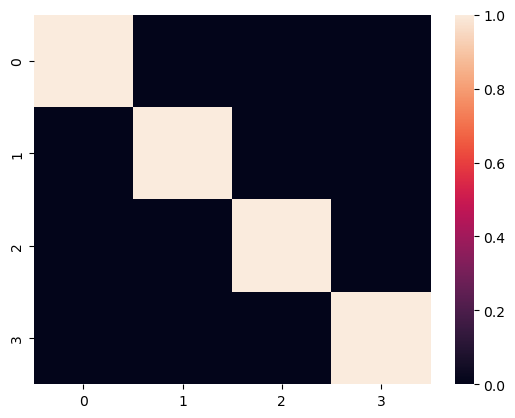

In [200]:
sns.heatmap(np.round(ovlp_mat,5)) #, annot=True, linewidths=.5)

# Using QMC one step

In [201]:
import bosonslater 
import pyscftools, mc
wf1 = bosonslater.BosonWF(mol, mf, mc=mcc)

nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
signb, phib = wf1.recompute(configs)
sign, logval = wf1.value()
val = np.exp(logval)
rho = val**2 
rho.shape

(1000,)

In [202]:
wf1.parameters['det_coeff']
wf1._det_map

array([[0, 0, 1, 1],
       [0, 1, 0, 1]])

In [203]:
# import slater 
# import pyscftools, mc
# wfs = slater.Slater(mol, mf, mc=mcc)

# nconfig = 1000
# mol, mf = pyscftools.recover_pyscf(scf_checkfile)
# configs = mc.initial_guess(mol, nconfig)
# signb, phib = wfs.recompute(configs)
# sign, logval = wfs.value()
# val = np.exp(logval)
# rho_s = val**2 
# rho_s.shape

In [204]:
# wfs.parameters['det_coeff']
# wfs._det_map

In [205]:
# rho

In [206]:
updet_sign, updet_val = wf1._dets[0]
dndet_sign, dndet_val = wf1._dets[1]

In [207]:
nup_i = np.einsum('ni, ni->ni', updet_sign, np.exp(updet_val)) # ui
nup_ij = np.einsum('ni, nj->nij', nup_i, nup_i) # ui
nup_i.shape

(1000, 2)

In [208]:
nup_i.shape

(1000, 2)

In [209]:
mf.get_ovlp().shape

(30, 30)

In [210]:
nup = np.einsum('ni, ni, nj, nj->nij', updet_sign, np.exp(updet_val), updet_sign, np.exp(updet_val)) # ui * uj
ndn = np.einsum('ni, ni, nj, nj->nij', dndet_sign, np.exp(dndet_val), dndet_sign, np.exp(dndet_val)) # di * dj 
psi_i = np.einsum('ni, ni, ni, ni->ni', updet_sign, np.exp(updet_val), dndet_sign, np.exp(dndet_val)) # ui * di 
nup.shape

(1000, 2, 2)

(2, 2)


<Axes: >

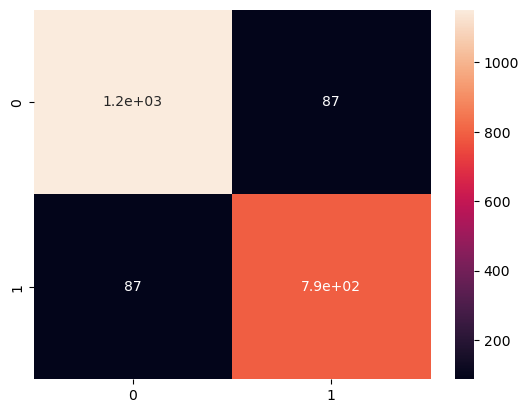

In [211]:
ovlp_ij = np.einsum('nij, nij, n ->ij', nup, ndn, 1./rho) # w(R) * (ui * uj) * (di * dj), w = 1 / rho
print(ovlp_ij.shape)
sns.heatmap(ovlp_ij, annot=True)

In [212]:
norm_i = np.einsum('ni, ni, n ->i', psi_i, psi_i, 1./rho) # ni = < psi_i * psi_i / rho > 
norm_ij = np.sqrt(np.einsum('i, j ->ij', norm_i, norm_i)) # sqrt(ni * nj)
print(norm_ij.shape)
norm_ij

(2, 2)


array([[1151.47275943,  954.93136022],
       [ 954.93136022,  791.93701741]])

<Axes: >

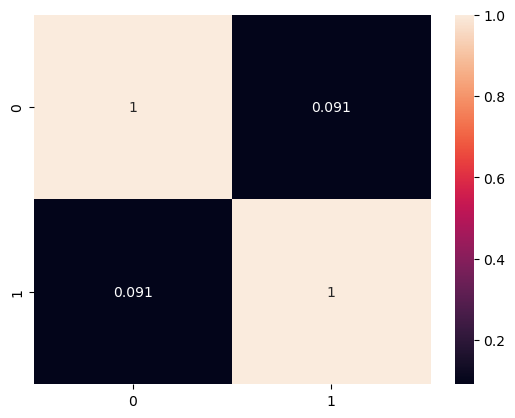

In [213]:
mat = ovlp_ij/norm_ij
sns.heatmap(mat, annot=True)


# Using QMC one step number 2 (correct)

In [217]:
import bosonslater 
import pyscftools, mc
wf1 = bosonslater.BosonWF(mol, mf, mc=mcc)

nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
signb, phib = wf1.recompute(configs)
sign, logval = wf1.value()
val = np.exp(logval)
rho = val**2 
rho.shape

(1000,)

In [218]:
wf1._det_occup[0]

[[0], [1]]

In [219]:
i = 0
j = 2
print((wf1._det_map[0][i], wf1._det_map[1][i]), (wf1._det_map[0][j], wf1._det_map[1][j]))

(0, 0) (1, 0)


In [224]:
wf1._det_occup

[[[0], [1]], [[0], [1]]]

In [225]:
updet_sign, updet_val = wf1._dets[0][:, :, wf1._det_map[0]]
dndet_sign, dndet_val = wf1._dets[1][:, :, wf1._det_map[1]]

In [226]:
nup = np.einsum('ni, ni, nj, nj->nij', updet_sign, np.exp(updet_val), updet_sign, np.exp(updet_val)) # ui * uj
ndn = np.einsum('ni, ni, nj, nj->nij', dndet_sign, np.exp(dndet_val), dndet_sign, np.exp(dndet_val)) # di * dj 
psi_i = np.einsum('ni, ni, ni, ni->ni', updet_sign, np.exp(updet_val), dndet_sign, np.exp(dndet_val)) # ui * di 
nup.shape


(1000, 4, 4)

(4, 4)


<Axes: >

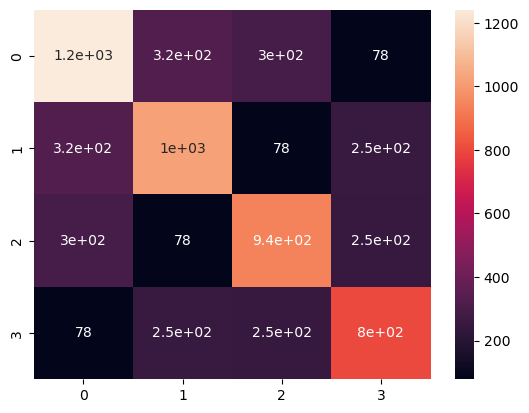

In [228]:
ovlp_ij = np.einsum('nij, nij, n ->ij', nup, ndn, 1./rho) # w(R) * (ui * uj) * (di * dj), w = 1 / rho
print(ovlp_ij.shape)
sns.heatmap(ovlp_ij, annot=True)

In [229]:
norm_i = np.einsum('ni, ni, n ->i', psi_i, psi_i, 1./rho) # ni = < psi_i * psi_i / rho > 
norm_ij = np.sqrt(np.einsum('i, j ->ij', norm_i, norm_i)) # sqrt(ni * nj)
print(norm_ij.shape)
norm_ij

(4, 4)


array([[1241.41162517, 1126.07993301, 1080.53737538,  994.44790836],
       [1126.07993301, 1021.46297796,  980.15149095,  902.06005109],
       [1080.53737538,  980.15149095,  940.51078299,  865.5776304 ],
       [ 994.44790836,  902.06005109,  865.5776304 ,  796.61461388]])

<Axes: >

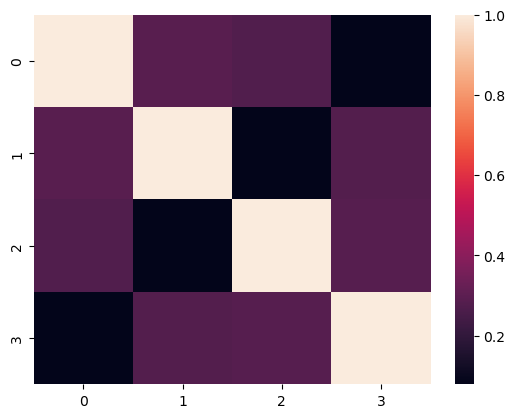

In [230]:
mat = ovlp_ij/norm_ij
sns.heatmap(mat) #, annot=True)

# QMC single step try 3

In [231]:
import bosonslater 
import pyscftools, mc
boson_wf = bosonslater.BosonWF(mol, mf, mc=mcc)

nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
signb, phib = boson_wf.recompute(configs)
sign, logval = boson_wf.value()
val = np.exp(logval)
rho = val**2 
rho.shape

(1000,)

In [232]:
updet_sign, updet_val = boson_wf._dets[0][:, :, boson_wf._det_map[0]]
dndet_sign, dndet_val = boson_wf._dets[1][:, :, boson_wf._det_map[1]]

det_dim_up = boson_wf._dets[0][1].shape[-1]
det_dim_dn = boson_wf._dets[1][1].shape[-1]
det_dim = det_dim_up * det_dim_dn

occ_arr_shape = (2, det_dim, num_ao)
occ_arr = np.zeros(occ_arr_shape)
for i in range(det_dim):
    up_i = boson_wf._det_map[0,i]
    dn_i = boson_wf._det_map[1,i]
    occ_arr[0, i][boson_wf._det_occup[0][up_i]] = 1
    occ_arr[1, i][boson_wf._det_occup[1][dn_i]] = 1



In [233]:
nup_i = np.einsum('ni, ni->ni', updet_sign, np.exp(updet_val)) # ui
ndn_i = np.einsum('ni, ni->ni', dndet_sign, np.exp(dndet_val)) # uj


mf_ovlp = mf.get_ovlp()
ovlp = np.einsum('io, op, jp->ij',occ_arr[0], mf_ovlp, occ_arr[0])


In [234]:
nup_ij = np.einsum('ni, ij, nj->nij', nup_i, ovlp, nup_i) # ui * uj
ndn_ij = np.einsum('ni, ij, nj->nij', ndn_i, ovlp, ndn_i) # ui * uj

ovlp_ij = np.einsum('nij, nij, n ->ij', nup_ij, ndn_ij, 1./rho) # w(R) * (ui * uj) * (di * dj), w = 1 / rho
# ovlp_ij_avg = np.average(ovlp_ij, axis=0)

psi_i = np.einsum('ni, ni, ni, ni->ni', updet_sign, np.exp(updet_val), dndet_sign, np.exp(dndet_val)) # ui * di 
norm_i = np.einsum('ni, ni, n ->i', psi_i, psi_i, 1./rho)
norm_ij = np.sqrt(np.einsum('i, j ->ij', norm_i, norm_i)) # sqrt(ni * nj)


<Axes: >

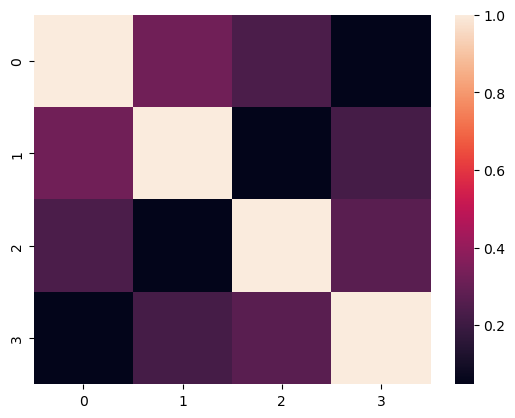

In [235]:
mat = ovlp_ij/norm_ij
sns.heatmap(mat) #, annot=True)

# Testing in parallel code

In [267]:
import h5py 
import numpy as np
import copy
import matplotlib.pyplot as plt


In [421]:
def plot_delta_ovlp(filename="abvmc.hdf5", discard = 2, annot=True):
    f = h5py.File(filename, "r")    
    keys = f.keys()
    
    fig, ax = plt.subplots(3, 2, figsize = (12, 15))    
    ovlp_ij_raw=np.array(f['excitationsovlp_ij'])
    delta_ij_raw=np.array(f['excitationsdelta'])
    discard = 2
    ovlp_ij = np.average(ovlp_ij_raw[discard:], axis=0)
    # plt.figure()
    sns.heatmap(ovlp_ij, ax=ax[0, 0], annot=annot)
    ax[0, 0].set_title('Overlap matrix')
    # plt.title('Overlap matrix')

    ovlp_ij_std = np.std(ovlp_ij_raw[discard:], axis=0)
    sns.heatmap(ovlp_ij_std, ax=ax[1, 0], annot=annot)
    ax[1, 0].set_title('Standard deviation of overlap matrix')
    
    filtered_ovlp_ij = copy.deepcopy(ovlp_ij)
    filtered_ovlp_ij[ovlp_ij_std>np.abs(ovlp_ij)] = 0
    sns.heatmap(filtered_ovlp_ij, ax=ax[2, 0], annot=annot)
    ax[2, 0].set_title('Filtered overlap matrix')
    


    delta_ij = np.average(delta_ij_raw[discard:], axis=0)
    sns.heatmap(delta_ij, ax=ax[0, 1], annot=annot)
    ax[0, 1].set_title('Delta matrix')
                       
    delta_ij_std = np.std(delta_ij_raw[discard:], axis=0)
    sns.heatmap(delta_ij_std, ax=ax[1, 1], annot=annot)
    ax[1, 1].set_title('Standard deviation of delta matrix')
    

    filtered_delta_ij = copy.deepcopy(delta_ij)
    filtered_delta_ij[delta_ij_std>np.abs(delta_ij)] = 0
    sns.heatmap(filtered_delta_ij, ax=ax[2, 1], annot=annot)
    ax[2, 1].set_title('Filtered Delta matrix')
    
    return {'filtered': [filtered_ovlp_ij, filtered_delta_ij], 
            'raw': [ovlp_ij_raw, delta_ij_raw]}
# res = plot_delta_ovlp()

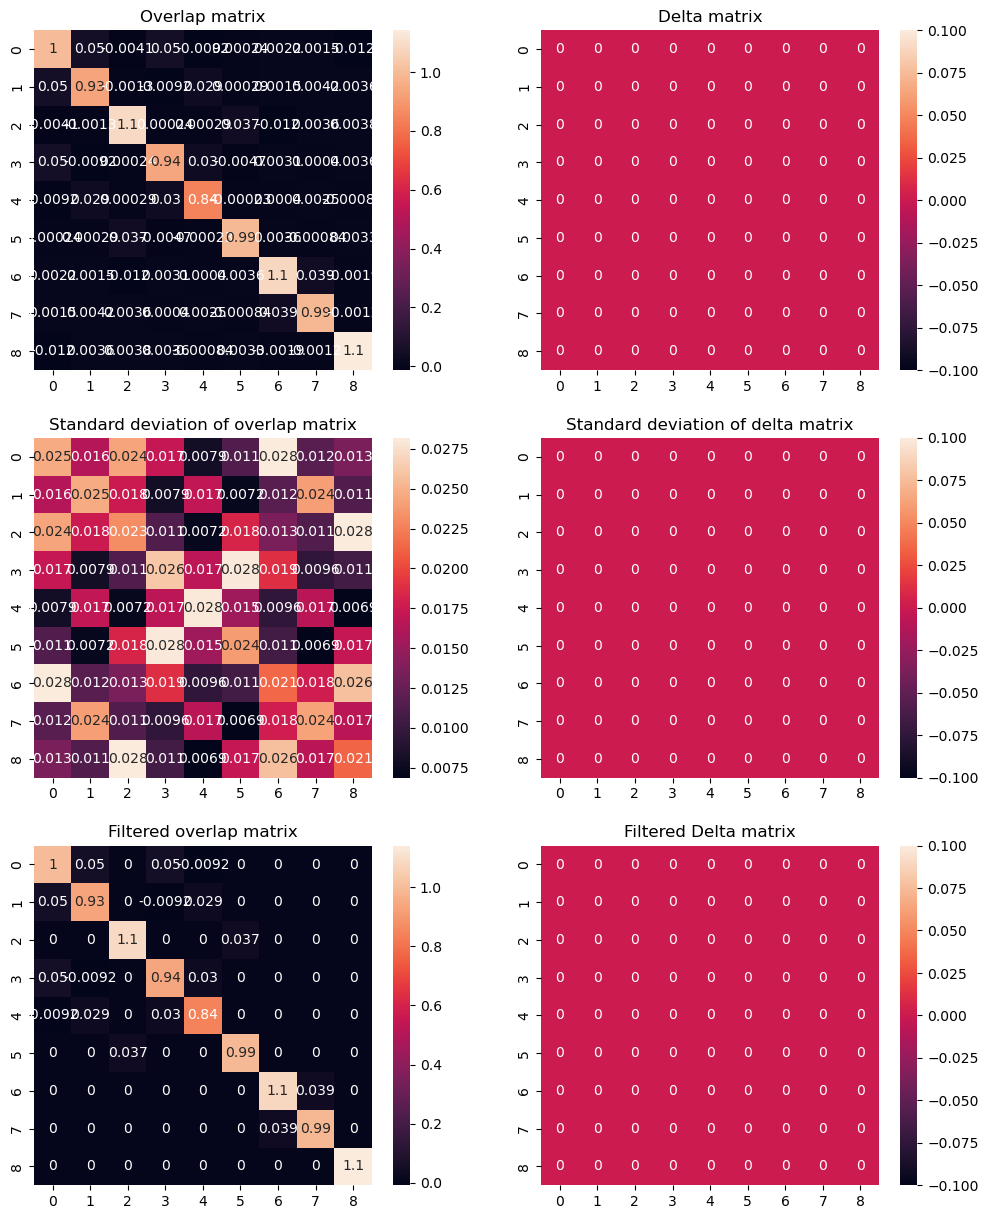

In [422]:
res = plot_delta_ovlp("abvmc-he-4.hdf5", discard=10, annot=True)

In [285]:
res['raw'][0][:, 0,1]

array([-0.02929397, -0.16873017, -0.1956245 , -0.2210991 , -0.19238353,
       -0.20307294, -0.21894144, -0.22672775, -0.19095744, -0.21467963,
       -0.20139311, -0.18375311, -0.23979194, -0.257615  , -0.21503253,
       -0.20731429, -0.20728801, -0.2719626 , -0.25638388, -0.24000436,
       -0.19223639, -0.21760297, -0.20796115, -0.2105218 , -0.22759933,
       -0.19917046, -0.21742951, -0.22875898, -0.23315897, -0.22782349,
       -0.22710258, -0.21703373, -0.21972624, -0.22167688, -0.19051019,
       -0.19773431, -0.2349701 , -0.24442353, -0.25820213, -0.2421161 ,
       -0.23216257, -0.2379807 , -0.25422389, -0.28171697, -0.19191649,
       -0.21773179, -0.23385796, -0.24667324, -0.25060923, -0.22272609,
       -0.20200774, -0.20898294, -0.23499571, -0.20589666, -0.21975308,
       -0.20096645, -0.19124632, -0.19241399, -0.22577595, -0.23181759,
       -0.21587298, -0.22942706, -0.23557523, -0.22337531, -0.21609507,
       -0.24348415, -0.25178892, -0.23527508, -0.24604692, -0.20

# Testing Lucas Wagner's code 

In [286]:
import pyqmc.api as pyq
from wftools import generate_slater

In [287]:
mcc.ci

FCIvector([[ 0.99897607,  0.00661145],
           [ 0.00661145, -0.04426495]])

In [288]:
configs = pyq.initial_guess(mol, 2000)
_, configs = pyq.vmc(wf1, configs)

In [289]:
wfs = []
num_det = mcc.ci.shape[0] * mcc.ci.shape[1]
for i in range(mcc.ci.shape[0]):
    for j in range(mcc.ci.shape[1]):
        mc0 = copy.copy(mcc)
        mc0.ci = mcc.ci * 0
        mc0.ci[i, j] = 1
        wf0, _ = generate_slater(mol, mf, mc=mc0, optimize_determinants=False)
        wfs.append(wf0)

In [290]:
from sample_many import sample_overlap
from accumulators_multiwf import EnergyAccumulatorMultipleWF

In [314]:
energy = EnergyAccumulatorMultipleWF(pyq.EnergyAccumulator(mol))
data_weighted, data_unweighted, configs = sample_overlap(
        wfs, configs, energy, nsteps=20, nblocks=5
)

In [315]:
y = data_unweighted['overlap']

In [316]:
wfs[1]._det_occup

[[[0], [1]], [[0], [1]]]

In [317]:
y

array([[[ 1.02214034e+00, -1.21151002e-02, -1.16982379e-02,
         -2.28202809e-04],
        [-1.21151002e-02,  9.95146299e-01, -2.28202809e-04,
         -8.98991632e-03],
        [-1.16982379e-02, -2.28202809e-04,  9.99361121e-01,
         -1.35302242e-02],
        [-2.28202809e-04, -8.98991632e-03, -1.35302242e-02,
          9.83352245e-01]],

       [[ 9.98380792e-01, -1.57660945e-02,  9.71353462e-03,
          7.56119373e-03],
        [-1.57660945e-02,  9.70002211e-01,  7.56119373e-03,
          2.09719472e-02],
        [ 9.71353462e-03,  7.56119373e-03,  1.01497902e+00,
         -4.77520477e-04],
        [ 7.56119373e-03,  2.09719472e-02, -4.77520477e-04,
          1.01663798e+00]],

       [[ 9.92114772e-01, -5.50048949e-03,  1.03593009e-02,
          4.49626403e-03],
        [-5.50048949e-03,  9.80135910e-01,  4.49626403e-03,
          1.71353938e-02],
        [ 1.03593009e-02,  4.49626403e-03,  1.01570238e+00,
         -4.80714152e-03],
        [ 4.49626403e-03,  1.71353938e-

In [318]:
# discard = 3

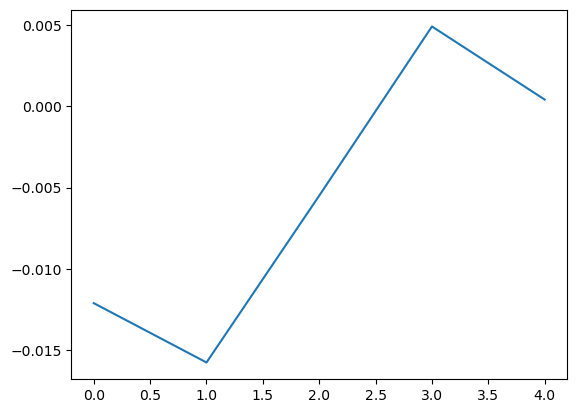

In [320]:
plt.plot(y[:,0,1])

In [263]:
y[discard:]

array([[[ 1.01439703e+00,  4.37118191e-04, -1.48328229e-02,
         -1.05255368e-03],
        [ 4.37118191e-04,  1.01004894e+00, -1.05255368e-03,
         -1.68538531e-02],
        [-1.48328229e-02, -1.05255368e-03,  9.89693304e-01,
         -1.49556103e-03],
        [-1.05255368e-03, -1.68538531e-02, -1.49556103e-03,
          9.85860723e-01]]])

<Axes: >

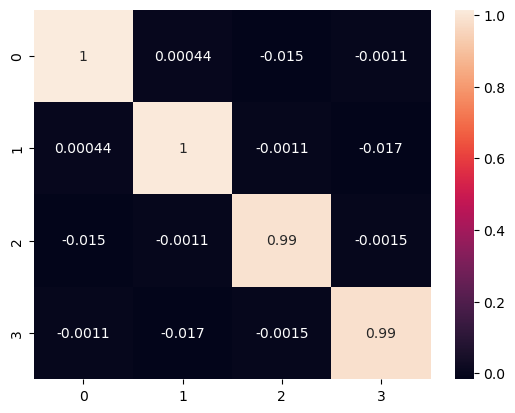

In [262]:
y_avg = np.average(y[discard:], axis=0)
sns.heatmap(y_avg, annot=True)

<Axes: >

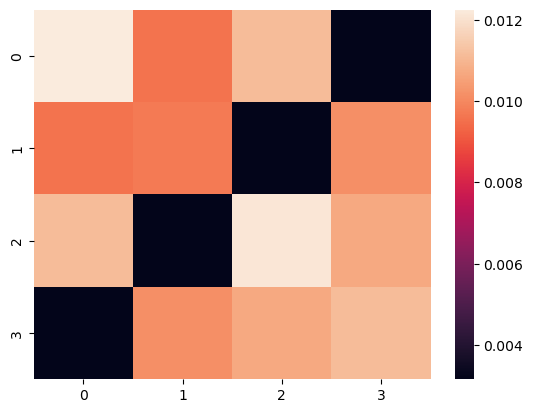

In [251]:
y_std = np.std(y[discard:], axis=0)
sns.heatmap(y_std) #, annot=True)

<Axes: >

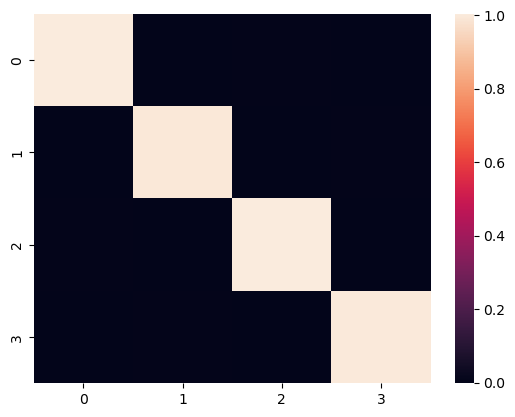

In [252]:
import copy
nom_new = copy.deepcopy(y_avg)
nom_new[y_avg>np.abs(y_avg)] = 0
sns.heatmap(nom_new) #,  linewidths=.5)

# Lucas Wagner's code vs single shot

In [377]:
import pyqmc.api as pyq
from wftools import generate_slater

In [378]:
configs = pyq.initial_guess(mol, 2000)
_, configs = pyq.vmc(wf1, configs)
configs.configs

array([[[-3.21511901e-01, -3.77837457e-01, -8.16764467e-02],
        [-1.11975280e-01,  6.32288840e-03,  3.41055452e-01]],

       [[ 2.53764576e-02, -2.13164648e-01,  2.27988808e-01],
        [ 4.26996148e-01,  5.18727286e-01,  2.08762297e-03]],

       [[-1.61997385e+00,  1.18388120e-02,  1.64592320e+00],
        [ 1.09717439e+00,  8.17301111e-01, -4.33426582e-01]],

       ...,

       [[ 2.83985531e-01,  1.05725811e-01, -2.16480735e+00],
        [ 3.23830619e-01,  1.68180222e-01,  4.15118962e-01]],

       [[ 2.05097847e-01,  5.42326730e-01, -2.50162175e-01],
        [-7.96319191e-01, -9.62257295e-02, -4.25591804e-01]],

       [[-2.86083750e-01, -4.27592447e-01, -7.12185978e-02],
        [ 5.31821135e-02, -4.26415409e-01, -5.44011143e-01]]])

In [379]:
wfs = []
num_det = mcc.ci.shape[0] * mcc.ci.shape[1]
for i in range(mcc.ci.shape[0]):
    for j in range(mcc.ci.shape[1]):
        mc0 = copy.copy(mcc)
        mc0.ci = mcc.ci * 0
        mc0.ci[i, j] = 1
        wf0, _ = generate_slater(mol, mf, mc=mc0, optimize_determinants=False)
        wfs.append(wf0)

In [380]:
import importlib, sample_many
modules = [sample_many] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)

from sample_many import sample_overlap
from accumulators_multiwf import EnergyAccumulatorMultipleWF

In [381]:
energy = EnergyAccumulatorMultipleWF(pyq.EnergyAccumulator(mol))
data_weighted, data_unweighted, configs = sample_overlap(
        wfs, configs, energy, nsteps=1, nblocks=1
)

In [405]:
e = 0
grads = [np.real(wf.gradient(e, configs.electron(e)).T) for wf in wfs]
vals = [np.real(wf.value()) for wf in wfs]
grad = mc.limdrift(np.mean(grads, axis=0))
grad



array([[ 0.06442582, -0.42068603, -0.90491578],
       [ 0.19640118,  0.27439152,  0.9413479 ],
       [ 0.82493096, -0.50081841,  0.26204931],
       ...,
       [-0.88232095, -0.3619124 , -0.30088062],
       [ 0.18601503,  0.06356825, -0.06744834],
       [ 0.65399838,  0.71315579, -0.25237856]])

In [412]:
import bosonslater, jastrowspin
wave_functions = wf.wf_factors
for wave in wave_functions:
    if isinstance(wave, bosonslater.BosonWF):
        boson_wf = wave
    if isinstance(wave, jastrowspin.JastrowSpin):
        jastrow_wf = wave       
                
g, _, _ = boson_wf.gradient_value(e, configs.electron(e))
gradb = mc.limdrift(np.real(g.T))
valueb = boson_wf.value()
gradb

array([[ 0.06442582, -0.42068603, -0.90491578],
       [ 0.19640118,  0.27439152,  0.9413479 ],
       [-0.82493096,  0.50081841, -0.26204931],
       ...,
       [ 0.88232095,  0.3619124 ,  0.30088062],
       [-0.1520526 , -0.05196202,  0.05513369],
       [ 0.65399838,  0.71315579, -0.25237856]])

In [413]:
grad-gradb

array([[ 4.16333634e-17, -3.88578059e-16,  2.22044605e-16],
       [-2.77555756e-17, -5.55111512e-17,  0.00000000e+00],
       [ 1.64986191e+00, -1.00163681e+00,  5.24098627e-01],
       ...,
       [-1.76464191e+00, -7.23824802e-01, -6.01761247e-01],
       [ 3.38067639e-01,  1.15530270e-01, -1.22582032e-01],
       [ 2.22044605e-16, -1.11022302e-16,  0.00000000e+00]])

In [415]:
vals

[array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [-1.05315181, -5.48064887, -2.45823899, ..., -2.73187124,
         -2.93537806, -2.19638654]]),
 array([[-1.        ,  1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.59013243, -5.90310447, -3.51581044, ..., -3.43045689,
         -3.65281231, -3.15537352]]),
 array([[-1.        ,  1.        , -1.        , ...,  1.        ,
          1.        , -1.        ],
        [-1.75397117, -4.56943436, -3.2175507 , ..., -9.58645704,
         -4.68072096, -2.8888426 ]]),
 array([[  1.        ,   1.        ,   1.        , ...,  -1.        ,
          -1.        ,   1.        ],
        [ -2.29095179,  -4.99188996,  -4.27512215, ..., -10.2850427 ,
          -5.3981552 ,  -3.84782958]])]

In [397]:
np.random.seed(seed=1)

def rolling_average(block, data, nsteps):
    for k, it in data.items():
        if k not in block:
            block[k] = np.zeros((*it.shape,), dtype=it.dtype)
        block[k] += it / nsteps

def sample_overlap_block(wfs, configs, tstep, nsteps, energy):
    for wf in wfs:
        wf.recompute(configs)
    weighted_block = {}
    unweighted_block = {"acceptance": 0.0}
    nconf, nelec = configs.configs.shape[:2]

    for n in range(nsteps):
        for e in range(nelec):  # a sweep
            # Propose move
            grads = [np.real(wf.gradient(e, configs.electron(e)).T) for wf in wfs]
            grad = mc.limdrift(np.mean(grads, axis=0))
            gauss = np.random.normal(scale=np.sqrt(tstep), size=(nconf, 3))
            newcoorde = configs.configs[:, e, :] + gauss + grad * tstep
            newcoorde = configs.make_irreducible(e, newcoorde)

            # Compute reverse move
            grads, vals, saved_values = list(
                zip(*[wf.gradient_value(e, newcoorde) for wf in wfs])
            )
            grads = [np.real(g.T) for g in grads]
            new_grad = mc.limdrift(np.mean(grads, axis=0))
            forward = np.sum(gauss**2, axis=1)
            backward = np.sum((gauss + tstep * (grad + new_grad)) ** 2, axis=1)

            # Acceptance
            t_prob = np.exp(1 / (2 * tstep) * (forward - backward))
            wf_ratios = np.abs(vals) ** 2
            log_values = np.real(np.array([wf.value()[1] for wf in wfs]))
            weights = np.exp(2 * (log_values - log_values[0]))

            ratio = (
                t_prob * np.sum(wf_ratios * weights, axis=0) / weights.sum(axis=0)
            )
            accept = ratio > np.random.rand(nconf)
            # block_avg["acceptance"][n] += accept.mean() / nelec

            # Update wave function
            configs.move(e, newcoorde, accept)
            for wf, saved in zip(wfs, saved_values):
                wf.updateinternals(
                    e, newcoorde, configs, mask=accept, saved_values=saved
                )

        weights = compute_weights(wfs)
        unweighted_dat={}
        unweighted_dat['overlap'] = np.mean(weights, axis=-1)
        rolling_average(unweighted_block, unweighted_dat, nsteps)
        # Collect rolling average
        if energy is not None:
            weighted_dat = energy.avg(configs, wfs, weights)
            rolling_average(weighted_block, weighted_dat, nsteps)

    return weighted_block, unweighted_block, configs
sample_overlap_block(wfs, configs, 0.5, 1, None)

({},
 {'acceptance': 0.0,
  'overlap': array([[ 1.44878628, -0.30593973, -0.29080798,  0.07501213],
         [-0.30593973,  0.92692843,  0.07501213, -0.17520976],
         [-0.29080798,  0.07501213,  0.97731002, -0.17456999],
         [ 0.07501213, -0.17520976, -0.17456999,  0.64697527]])},
 <pyqmc.coord.OpenConfigs at 0x3927a5f10>)

In [398]:
# Now my code

In [399]:
import importlib, bosonaccumulators
modules = [bosonaccumulators] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)

dm = mf.make_rdm1()
mf.dm = dm

accumulators = {}
accumulators['energy'] = bosonaccumulators.ABQMCEnergyAccumulator(mf)
accumulators['excitations'] = bosonaccumulators.ABVMCMatrixAccumulator()

np.random.seed(seed=1)

def vmc_worker(wf, configs, tstep, nsteps, accumulators):
    """
    Run VMC for nsteps.

    :return: a dictionary of averages from each accumulator.
    """
    nconf, nelec, _ = configs.configs.shape
    block_avg = {}
    wf.recompute(configs)
    for _ in range(nsteps):
        acc = 0.0
        for e in range(nelec):
            # Propose move
            g, _, _ = wf.gradient_value(e, configs.electron(e))
            grad = mc.limdrift(np.real(g.T))
            gauss = np.random.normal(scale=np.sqrt(tstep), size=(nconf, 3))
            newcoorde = configs.configs[:, e, :] + gauss + grad * tstep
            newcoorde = configs.make_irreducible(e, newcoorde)

            # Compute reverse move
            g, new_val, saved = wf.gradient_value(e, newcoorde)
            new_grad = mc.limdrift(np.real(g.T))
            forward = np.sum(gauss**2, axis=1)
            backward = np.sum((gauss + tstep * (grad + new_grad)) ** 2, axis=1)

            # Acceptance
            t_prob = np.exp(1 / (2 * tstep) * (forward - backward))
            ratio = np.abs(new_val) ** 2 * t_prob
            accept = ratio > np.random.rand(nconf)

            # Update wave function
            configs.move(e, newcoorde, accept)
            wf.updateinternals(e, newcoorde, configs, mask=accept, saved_values=saved)
            acc += np.mean(accept) / nelec

        # Rolling average on step
        for k, accumulator in accumulators.items():
            dat = accumulator.avg(configs, wf)
            for m, res in dat.items():
                if k + m not in block_avg:
                    block_avg[k + m] = res / nsteps
                else:
                    block_avg[k + m] += res / nsteps
        block_avg["acceptance"] = acc
    return block_avg, configs
vmc_worker(wf, configs, 0.5, 1, accumulators)    

({'energyka': 0.823337700329527,
  'energykb': -0.7247967310061324,
  'energygrad2': 6.585108487196146,
  'energyke': 0.09854096932339465,
  'energyee': 0.8460218330023086,
  'energyei': -6.870663487341977,
  'energyvh': 3.6647825648901815,
  'energyvxc': -1.1499302886501264,
  'energycorr': -1.8321491241009964,
  'energyii': 0.0,
  'energytotal': -3.4024385980153484,
  'excitationsdelta': array([[-0.73544091,  0.2287361 ,  0.22032184, -0.03021238],
         [ 0.25466892, -0.39490482, -0.04279816,  0.15954274],
         [ 0.24999373, -0.04476023, -0.3858901 ,  0.15569885],
         [-0.05734602,  0.16975557,  0.16451655, -0.17373916]]),
  'excitationsovlp_ij': array([[ 1.30629334, -0.26484093, -0.23909083,  0.06259975],
         [-0.26484093,  0.95049777,  0.06259975, -0.16794941],
         [-0.23909083,  0.06259975,  0.99749283, -0.17375677],
         [ 0.06259975, -0.16794941, -0.17375677,  0.74571606]]),
  'acceptance': 0.4725},
 <pyqmc.coord.OpenConfigs at 0x3927a5f10>)